# Gas Price Prediction with SARIMA Model

This notebook contains the SARIMA model used in the thesis project. The experiment includes two extracted datasets for a predefined gas station. The first dataset contains the daily maximum prices while the other contains data of hourly granularity. <br>The datasets are modeled with ARIMA and SARIMA respectively. The models are embedded into a loop to perform rolling forecasts. This method shall ensure accurate predictions based on the entire price history of the dataset. The models are built for direct comparison to recurrent neural networks.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn.metrics as metrics
from math import sqrt

# Metrics

The following metrics are used:
+ Mean Absolute Error           **(MAE)**
+ Mean Squared Error            **(MSE)**
+ Root Mean Squared Error       **(RMSE)**
+ Mean Abs. Percentage Error    **(MAPE)**$*$
+ Mean Percentage Error         **(MPE)**

*$*$ Function **mean_absolute_percentage_error** has been adapted from **[2]**. **mean_percentage_error** is based on this.*

In [2]:
def mean_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean( y_true != y_pred ) *100

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
def print_metrics(prediction,target, rnd):
    
    if rnd == True: #if rounded data is investigated
        
        #cast to int does not harm data as it is already rounded when passed to function; 
        #cast is not necessary, but performed for completeness.
        prediction = np.asarray(prediction)
        prediction = prediction.astype(np.int64) 
        prediction = prediction.reshape(target.shape)
        
    else:
        prediction = np.asarray(prediction)
        prediction = prediction.reshape(target.shape)
        target = target.astype(np.float64)
        
    #Array gets shortened by 7 for comparability of results to RNNs
    mae  = metrics.mean_absolute_error(target[:len(prediction)-7], prediction[:len(prediction)-7])
    mse  = metrics.mean_squared_error(target[:len(prediction)-7], prediction[:len(prediction)-7])
    mpe = mean_percentage_error(target[:len(prediction)-7], prediction[:len(prediction)-7])
    mape = mean_absolute_percentage_error(target[:len(prediction)-7], prediction[:len(prediction)-7])
    
    print("Mean Absolute Error: ", mae, sep="\t\t")
    print("Mean Squared Error: ", mse, sep="\t\t")
    print("Root Mean Squared Error: ", np.sqrt(mse), sep="\t")
    print("Mean Abs. Percentage Error: ", mape, sep="\t")
    print("Mean Percentage Error: ", mpe, sep="\t\t")


# Model Building

## 1. Data Loading

In the following example, a preprocessed gas price dataset is used. The data contains the hourly prices in the period from 06-2014 - 05-2016. The dataset has been extracted from **[1]**.

In [5]:
df = pd.read_csv('../Data/First_station_hour.csv', sep = ';')

In [6]:
df.head()

,timestamp,stid,e10
0,08.06.2014 09:00,105307c4-8562-45e4-9cc2-a04ef4a19400,152
1,08.06.2014 10:00,105307c4-8562-45e4-9cc2-a04ef4a19400,152
2,08.06.2014 11:00,105307c4-8562-45e4-9cc2-a04ef4a19400,152
3,08.06.2014 12:00,105307c4-8562-45e4-9cc2-a04ef4a19400,152
4,08.06.2014 13:00,105307c4-8562-45e4-9cc2-a04ef4a19400,152


In [7]:
df.isnull().values.any()

False

## 2. Data Preparation

In Data Preprocessing step, all unnecessary columns are dropped.

In [8]:
df.dtypes

timestamp    object
stid         object
e10           int64
dtype: object

#### Step 2.1: Prepare dataframe
At this point, unnecessary columns are dropped.

In [9]:
df = df.drop('stid', axis=1)

In [10]:
df = df.drop('timestamp', axis=1)

#### Step 2.2: First visual inspection
A first visualization gives useful insights into the time series. The plot shows <BR>

* Indicators of a seasonal pattern.
* Possible outliers.
* Increasing volatility of prices past Oct 2015.

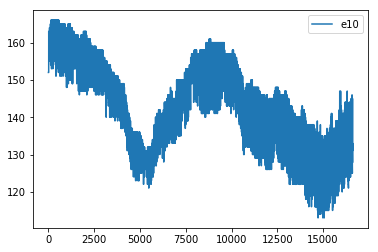

In [11]:
df.plot()
plt.show()

A strong, recurring pattern gets revealed by looking closely into the dataframe. This pattern has a period of 24, representing one day.

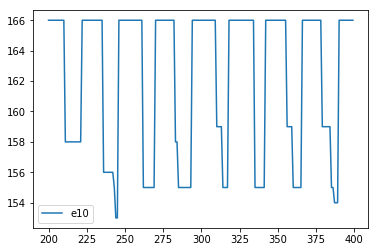

In [12]:
df[200:400].plot()
plt.show()

In [13]:
df.describe()

,e10
count,16622.000000
mean,142.720792
std,12.501882
min,113.000000
25%,133.000000
50%,144.000000
75%,152.000000
max,166.000000


## 3. Test for Stationarity

This function performs the Augmented Dickey-Fuller-test and prints out its statistics. The ADF-test is a frequently used method to determine the stationarity of a time series and thus the correct order of differencing (d). <br>
The function plots the time series, and additonally gives useful insigths by plotting the rolling mean. Window size is fixed to 7 by default.

Function **test_stationarity** has been adapted from **[3]**. *(modified)*

In [14]:
def test_stationarity(ts, full):
    
    if full == True:

        #Determing rolling statistics
        rolmean = pd.rolling_mean(ts, window=7)

        #Plot rolling statistics:
        orig = plt.plot(ts, color='k',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')

        width = 10
        length = 6

        plt.legend(loc='best')
        plt.title('Rolling Mean')
        plt.rcParams['figure.figsize'] = (width, length)
        plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ( 'Results of Dickey-Fuller Test:' )
    dftest = adfuller(ts.iloc[:,0].values, autolag=None)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print ( dfoutput )

#### Step 3.1: Check for stationarity

At this point, the stationarity of the time series must be investigated. The reuslt of the ADF-test shows that the p-value is 0.39 (= 39%). Thus, the $h_0$ of remaining unit roots cannot be rejected. The $h_0$ can only be rejected if the p-value is less or equal to 0.05 (= 5%). <BR> <BR>
As a result, the time series must be differenced.

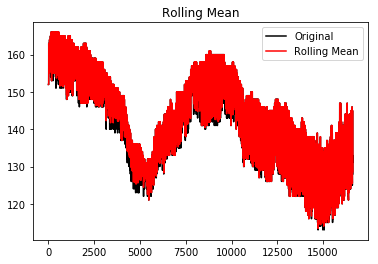

Results of Dickey-Fuller Test:
Test Statistic                    -1.779139
p-value                            0.390867
#Lags Used                        44.000000
Number of Observations Used    16577.000000
Critical Value (5%)               -2.861714
Critical Value (1%)               -3.430745
Critical Value (10%)              -2.566863
dtype: float64


In [15]:
test_stationarity(df, True)

#### Step 3.2: Compute first differences
Differencing is a built-in function in pandas. Differencing gets applied by computing the first differences  $\hat y_t = y_t - y_{t-1} $ for all observations. <br>
The original series gets shortened by the last observation. For this reason, the resulting **NA** value gets dropped.

In [16]:
ts_diff = df.diff()

In [17]:
ts_diff.isnull().values.any()

True

In [18]:
ts_diff = ts_diff.dropna()

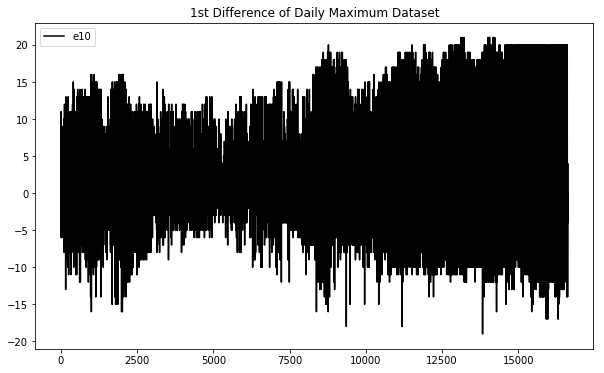

In [19]:
ts_diff.plot(color='k')
plt.title('1st Difference of Daily Maximum Dataset')
plt.show()

#### Step 3.3: Check for stationarity (again)

After that, the series of first differences is tested for stationarity. The result shows, that the p-value is very close to zero. In addition to that, the Test Statistic is far smaller than the Critical Vlaue (1%). Therefore, the $h_0$ must be rejected. <br><br>
The time series is now stationary. For the SARIMA model, an **order d = 1** is needed.

In [20]:
test_stationarity(ts_diff, False)

Results of Dickey-Fuller Test:
Test Statistic                   -31.845711
p-value                            0.000000
#Lags Used                        44.000000
Number of Observations Used    16576.000000
Critical Value (5%)               -2.861714
Critical Value (1%)               -3.430745
Critical Value (10%)              -2.566863
dtype: float64


## 4. Determine Model Orders p and q
Here, the ACF and PACF are computed. For this reason, the differenced time series gets investigated to determine the remaining SARIMA model parameter. For this reason, the ACF and PACF are plotted twice: first in a wider range (75lags) for seasonalities, and after that in a closer range (20lags) to determine order p and q.

In [21]:
lag_acf = acf(ts_diff, nlags=120)
lag_pacf = pacf(ts_diff, nlags=120)

In [22]:
acf_df   = pd.DataFrame(lag_acf[0:75])
acf_df_1 = pd.DataFrame(lag_acf[1:20])
pacf_df  = pd.DataFrame(lag_pacf[0:75])
pacf_df_1= pd.DataFrame(lag_pacf[1:20])

#### 5.1 Plot ACF and PACF (75Lags)

The ACF and PACF plot show significant recurring autocorrelations at **every $24^{th}$ lag**. This suggests that the **seaonality S = 24**.

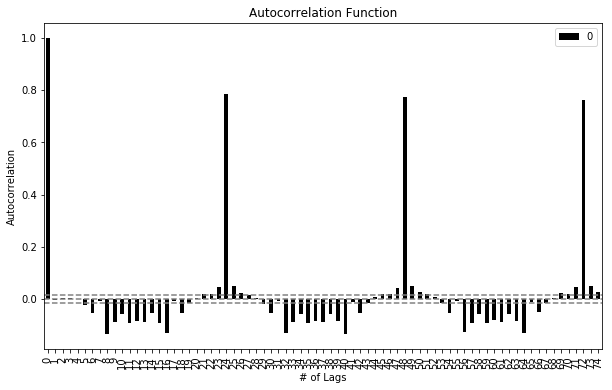

In [23]:
sig_neg= -1.96/np.sqrt(len(ts_diff))
sig_pos = 1.96/np.sqrt(len(ts_diff))
                        
                        
acf_df.plot(kind ='bar', color='k')
plt.axhline(y=0,       linestyle='--',color='gray')
plt.axhline(y=sig_pos, linestyle='--',color='gray')
plt.axhline(y=sig_neg, linestyle='--',color='gray')
                        
plt.title('Autocorrelation Function')
plt.xlabel('# of Lags') 
plt.ylabel('Autocorrelation')
plt.show()

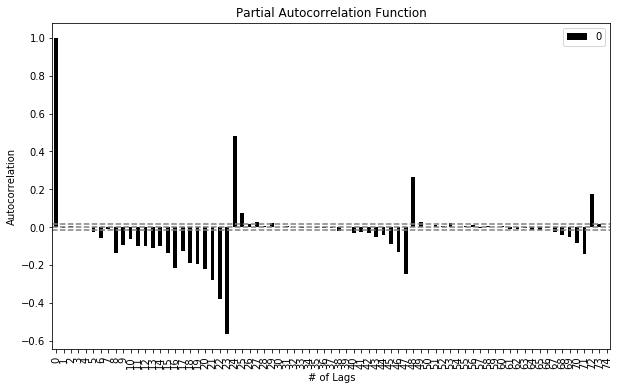

In [24]:
sig_neg= -1.96/np.sqrt(len(ts_diff))
sig_pos = 1.96/np.sqrt(len(ts_diff))
                        
                        
pacf_df.plot(kind ='bar', color='k')
plt.axhline(y=0,       linestyle='--',color='gray')
plt.axhline(y=sig_pos, linestyle='--',color='gray')
plt.axhline(y=sig_neg, linestyle='--',color='gray')

plt.title('Partial Autocorrelation Function')
plt.xlabel('# of Lags')
plt.ylabel('Autocorrelation')
plt.show()

#### 5.2 Plot ACF and PACF (20Lags)

For illustration purposes, the following plots have been shortened by the first autocorrelation. Therefore, the observed lags, displayed in the plots, must be increaded by one. <br>
Both, ACF and PACF plot, show negative autocorrelations. The first trespassing and thus significantly autocorrelation is at **lag 4**.<br><br>
Combining the observations of ACF and PACF plot, an **order q = 5** appears to be sufficient.

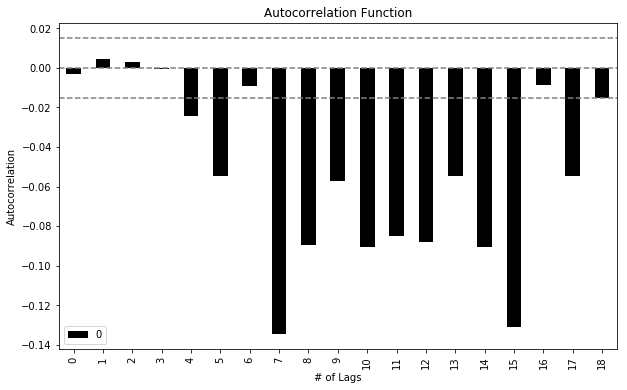

In [25]:
sig_neg= -1.96/np.sqrt(len(ts_diff))
sig_pos = 1.96/np.sqrt(len(ts_diff))
                        
                        
acf_df_1.plot(kind ='bar', color='k')
plt.axhline(y=0,       linestyle='--',color='gray')
plt.axhline(y=sig_pos, linestyle='--',color='gray')
plt.axhline(y=sig_neg, linestyle='--',color='gray')
                        
plt.title('Autocorrelation Function')
plt.xlabel('# of Lags') 
plt.ylabel('Autocorrelation')
plt.show()

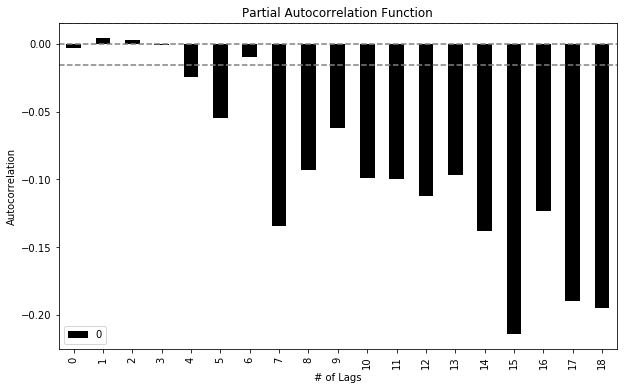

In [26]:
sig_neg= -1.96/np.sqrt(len(ts_diff))
sig_pos = 1.96/np.sqrt(len(ts_diff))
                        
                        
pacf_df_1.plot(kind ='bar', color='k')
plt.axhline(y=0,       linestyle='--',color='gray')
plt.axhline(y=sig_pos, linestyle='--',color='gray')
plt.axhline(y=sig_neg, linestyle='--',color='gray')

plt.title('Partial Autocorrelation Function')
plt.xlabel('# of Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Rolling Forecast with SARIMA

Rolling forecast of SARIMA model enables accurate multi-step predictions of time series. For gas price predictions, this method is even more suitable. In general, gas prices are volatile and thus long term forecasts are less reliable. <br><br>

For the hourly dataset, the model order SARIMA(0,1,5)(P,D,Q)$_{24}$ have already been identified. According to **[4]**, a positive seasonal pattern indicates seasonal AR(P) terms. After some try and error, the model parameters have been set to **SARIMA(0,1,5)(2,1,0)$_{24}$**. <br><br>

Due to performance reasons, it was not possible to continue with the original 80/20 (train/test) split. The SARIMA model gets fitted after each iteration, which leads to very long run times. Therefore, the experiments are performed on a test dataset of size 42. <br><br>

Statsmodels does not provide a sole SARIMA model. Instead, there is only a SARIMAX model available. However, leaving out the optional exogenous variable results in a regular SARIMA model. <br><br>


The **following code** has been adapted from **[5]**. *(modified)*

In [27]:
X = df.values
X = X.astype('float64')

train, test = X[0:16580], X[16580:len(X)]
history = [x for x in train]
m2_predictions = list()
m2_predictions_rnd = list()
for t in range(len(test)):
    model = SARIMAX(history, order=(0,1,5), seasonal_order=(2,1,0,24))
    model_fit = model.fit()                                         #disp=0
    output = model_fit.forecast()
    yhat_rnd = np.rint(output[0])
    yhat = output[0]
    m2_predictions.append(yhat)
    m2_predictions_rnd.append(yhat_rnd)
    obs = test[t]
    history.append(obs)
    if (t % 10) == 0:
        print('Durchlauf: {}'.format(t))

Durchlauf: 0
Durchlauf: 10
Durchlauf: 20
Durchlauf: 30
Durchlauf: 40


#### 5.1. Print AIC value
The Akaike Information Criterion is a measure of model quality. AIC is used to compare different models.

In [28]:
model_fit.aic

68455.66718318962

#### 5.2. Plot predictions
The plot reveals that the model has significant problems. The model introduces artificial price droppings and increases. This model is not suitable for the given task.

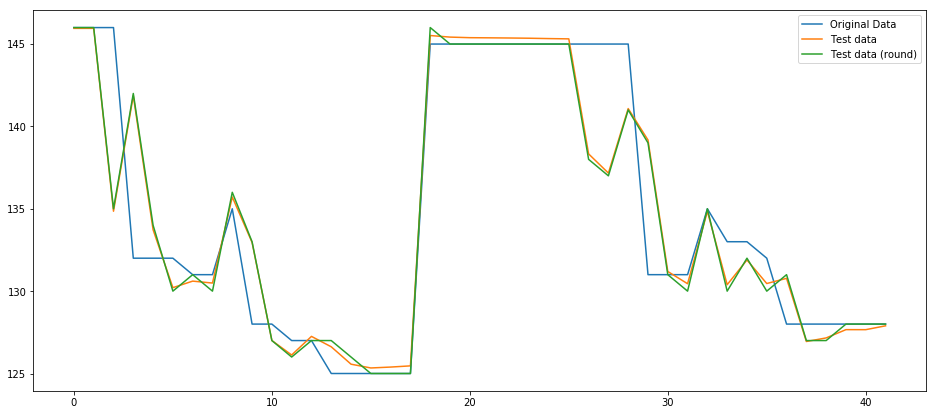

In [29]:
plt.figure(figsize=(16, 7))
plt.plot(test, label='Original Data')
plt.plot(m2_predictions, label='Test data')
plt.plot(m2_predictions_rnd, label='Test data (round)')
plt.legend()
plt.show()

#### 6.3. Print metrics

In [30]:
print_metrics(m2_predictions, test, False)

Mean Absolute Error: 		2.027798584687388
Mean Squared Error: 		13.03153136058506
Root Mean Squared Error: 	3.6099212402191077
Mean Abs. Percentage Error: 	1.4808532607665659
Mean Percentage Error: 		100.0


In [31]:
print_metrics(m2_predictions_rnd, test, True)

Mean Absolute Error: 		2.0
Mean Squared Error: 		13.371428571428572
Root Mean Squared Error: 	3.6566964013202643
Mean Abs. Percentage Error: 	1.462575986527853
Mean Percentage Error: 		54.285714285714285


## 7. Analysis of Residuals
Model adequacy can be determined by using the ACF on the model residuals. <br><br>

The Plots reveal, that there are significant autocorrelations remaining. Thus, there is information left. The model must be further improved.

In [32]:
resids = SARIMAXResults.resid(model_fit)

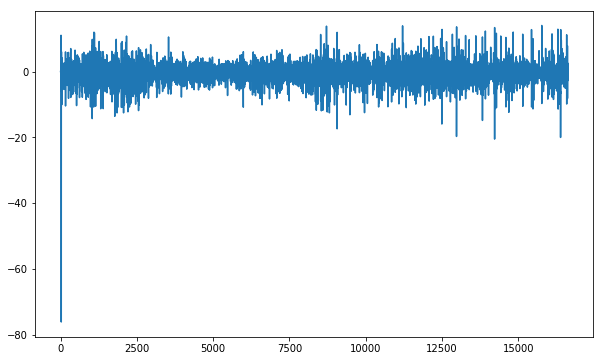

In [33]:
plt.plot(resids[1:])
plt.show()

In [34]:
lag_acf_resid = acf(resids[1:], nlags=120)

In [35]:
acf_resid    = pd.DataFrame(lag_acf_resid[0:50])
acf_resid_1  = pd.DataFrame(lag_acf_resid[1:50])

In [36]:
def plot_acf(residuals, acf):

    sig_neg = -1.96/np.sqrt(len(residuals))
    sig_pos = 1.96/np.sqrt(len(residuals))
                       
                        
    acf.plot(kind ='bar', color='k')
    plt.axhline(y=0,       linestyle='--',color='gray')
    plt.axhline(y=sig_pos, linestyle='--',color='gray')
    plt.axhline(y=sig_neg, linestyle='--',color='gray')
                        
    plt.title('Autocorrelation Function')
    plt.xlabel('# of Lags')
    plt.ylabel('Autocorrelation')   
    plt.show()

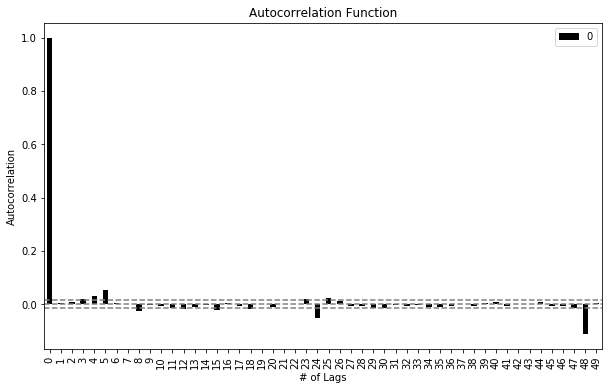

In [37]:
plot_acf(resids, acf_resid)

Without lag zero autocorrelation, the significant autocorrelations are more visible.

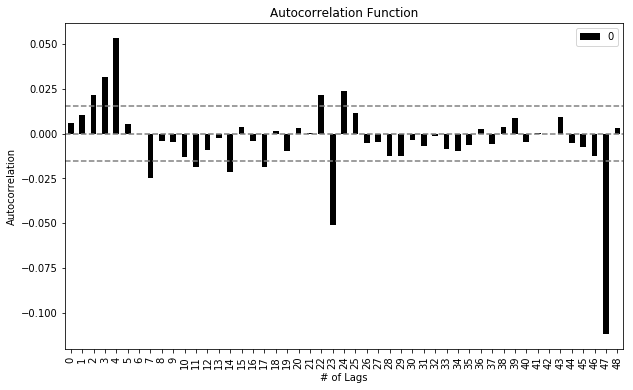

In [38]:
plot_acf(resids, acf_resid_1)

##### Dataset:

[1] Martin Kurz. *Historische Preisdaten*. 2017. Retrieved from https://creativecommons.tankerkoenig.de/ and licensed under CC-BY 4.0.

##### References:

[2] Antonín Hoskovec. *Mean absolute percentage error (MAPE) in Scikit-learn*. 2017. URL: https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn/294069#294069 (visited on 02/28/2018)

[3] Aarshay Jain. *A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python)*. 2016. URL: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ (visited on 02/28/2018)

[4] Robert Nau. *General seasonal ARIMA models: (0,1,1)x(0,1,1) etc.*. 2017. URL:https://people.duke.edu/~rnau/seasarim.htm. *(visited on 02/28/2018)*

[5] Jason Brownlee. *How to Make Out-of-Sample Forecasts with ARIMA in Python*. 2017. URL: https://machinelearningmastery.com/make-sample-forecasts-arima-python/. *(visited on 02/28/2018)*

[6] The Pennsylvania State University. *STAT 510 – Applied Time Series Analysis*. 2018. URL: https://onlinecourses.science.psu.edu/stat510/. *(visited on 02/28/2018)*